# 2D plotting of LES output vs. synthetic aperture radar (work in progress)
* The below notebook compares selected simulations against observational targets that were collected from satellite.
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [1]:

import glob, os
import geopy
import geopy.distance

os.getcwd()


'/user-data-home/comble-mip/notebooks/plotting'

In [2]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

In [3]:
## select times
Time_Vec = [2.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours

## set domain to be extracted
Spat_Window = 100.0 ## km


In [4]:
## convert to regular time
tprop = []
for toi in Time_Vec:
    tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
print (tprop)           

[numpy.datetime64('2020-03-13T02:00:00')]


In [5]:
## load sar imagery

sar_dir = "/data/project/comble-mip/sar_imagery/"
os.chdir(sar_dir)
counter_dat = 0
for file in glob.glob("*wind_level2.nc"):
    
    ## load file
    ds_sar = xr.open_dataset(sar_dir + file)
    
    ## time
    file_time = ds_sar['acquisition_time'].data
    
    ## for each requested model timestep, check if image covers right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            #print(LAT_MIN,LAT_MAX,LON_MIN,LON_MAX)
            
            SliceData = ds_sar.where((ds_sar['latitude'][:,:] > LAT_MIN) & 
                                     (ds_sar['latitude'][:,:] < LAT_MAX) & 
                                     (ds_sar['longitude'][:,:] > LON_MIN)& 
                                     (ds_sar['longitude'][:,:] < LON_MAX),drop=True)
            #print (SliceData['latitude'])
            
            ## select pixels within window
            pix_num = ((ds_sar['latitude'][:,:] > LAT_MIN) & 
                       (ds_sar['latitude'][:,:] < LAT_MAX) & 
                       (ds_sar['longitude'][:,:] > LON_MIN)& 
                       (ds_sar['longitude'][:,:] < LON_MAX)).sum()
            #print(pix_num)
            
            if pix_num > 0:
                
                ds_wind = SliceData['sar_wind'][:,:]
                ds_lat = SliceData['latitude'][:,:]
                ds_lon = SliceData['longitude'][:,:]
                
                da = xr.DataArray(
                    name = 'wspd',
                    data = ds_wind,
                    dims = ['y_dist','x_dist'],
                    coords = dict(
                        lon = (['y_dist','x_dist'],ds_lon.data),
                        lat = (['y_dist','x_dist'],ds_lat.data)
                    #dims = ['y','x'],
                    #coords = dict(
                    #    lon = (['y','x'],ds_lon.data),
                    #    lat = (['y','x'],ds_lat.data)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                print (ds_wind.shape)
                for jj in tqdm(range(ds_wind.shape[0])):
                    for ii in range(ds_wind.shape[1]):
                        da['x_dist'][jj,ii] = geopy.distance.geodesic((da['lat'][jj,ii],da['lon'][jj,ii]), 
                                                                      (da['lat'][jj,ii],Lon_OI)).km * np.sign((da['lon'][jj,ii].data - Lon_OI))
                        da['y_dist'][jj,ii] = geopy.distance.geodesic((da['lat'][jj,ii],da['lon'][jj,ii]), 
                                                                      (Lat_OI,da['lon'][jj,ii])).km * np.sign((da['lat'][jj,ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da.where((np.abs(da['y_dist'][:,:]) <= Spat_Window/2) & (np.abs(da['x_dist'][:,:]) <= Spat_Window/2),drop=True)
                
                da['x_round'] = np.round(da['x_dist'])
                da['y_round'] = np.round(da['y_dist'])
                
                da_stat_stack = xr.DataArray(name='wspd',coords=(np.unique(da['y_round']),np.unique(da['x_round'])))
                da_stat_stack = da_stat_stack.rename({'dim_0': 'y_round','dim_1': 'x_round'})
                
                countyy = -1
                for yy in tqdm(np.unique(da['y_round'])):
                    countxx = -1
                    for xx in np.unique(da['x_round']):
                        #print (da.where(da['x_round']==xx, drop=True).squeeze())
                        #sys.exit()
                        #print (da.where(da['x_round']==xx))
                        #da_sub = da[da['y_round'] == yy]
                        #da_stat = da_sub.groupby('x_round').mean() 
                        #da_stat['y_round'] = np.float64(yy)

                        da_sub = da.where((da['y_round'] == yy) & (da['x_round'] == xx),drop=True)
                        da_stat = da_sub.mean()
                        da_stat['y_round'] = np.float64(yy)
                        da_stat['x_round'] = np.float64(xx)
                        #print (da_stat)

                        da_stat_stack[countyy,countxx] = da_stat

                        #if (yy == np.unique(da['y_round'])[0] and xx == np.unique(da['x_round'])[0]):
                        #    #da_stat_stack = xr.concat([da_stat],dim=['x_round','y_round'])
                        #    da_stat_stack = da_stat
                        #else:
                        #    print (da_stat_stack)
                        #    print (da_stat)
                        #    da_stat_stack = xr.concat([da_stat_stack,da_stat],dim=['y_round'])

                        countxx+=-1

                    countyy+=-1
                
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['Source'] = file
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
    counter_dat += 1

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


2020-03-13T02:00:00
(308, 310)


100%|██████████| 168/168 [01:14<00:00,  2.27it/s]


In [6]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

var_vec_2d = ['us','vs']

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


In [7]:
## compute wind speed from model outputs
df_col_2d['wspd'] = np.sqrt(pow(df_col_2d['us'],2.) + pow(df_col_2d['vs'],2.))

/tmp/ipykernel_4043/2740631745.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_merge = xr.merge([df_col_2d['wspd'],da_stat_ststst.drop('time_diff')])['wspd']


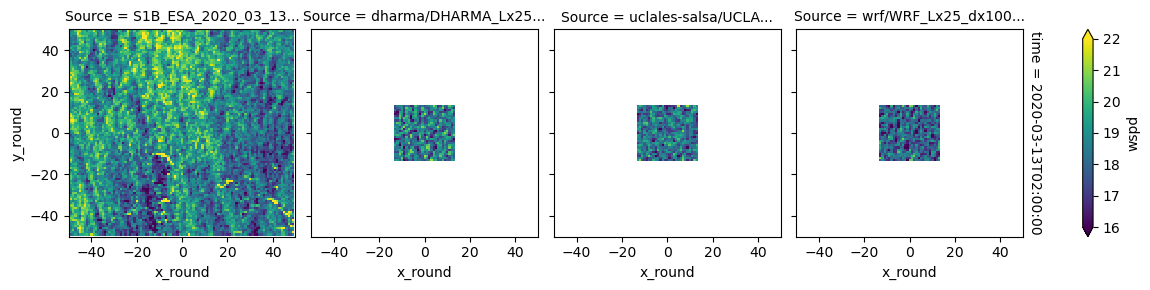

In [8]:
## merge obs and model and plot
ds_merge = xr.merge([df_col_2d['wspd'],da_stat_ststst.drop('time_diff')])['wspd']
ds_merge.plot(row='time',col='Source',vmin=16,vmax=22,xlim=(-50,50),ylim=(-50,50))